In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import numpy as np # linear algebra
import pandas as pd
import os
import shutil
import random
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns 

In [2]:
import os
import shutil
from tqdm import tqdm

split = ['train', 'test', 'val']
labels = ['NORMAL', 'PNEUMONIA']

# Source folder containing the files
source_folder = r'C:\Users\USER\Downloads\chest_xray'

# Destination folder to move the files to
destination_folder = r'C:\Users\USER\Documents\Pneumonia detection'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    for label in labels:
        os.makedirs(os.path.join(destination_folder, label))

for s in tqdm(split):
    for l in labels:
        sf = os.path.join(source_folder, s, l)
        df = os.path.join(destination_folder, l)
        
        # Get a list of all files in the source folder
        files = os.listdir(sf)

        # Copy each file from the source folder to the destination folder
        for file_name in files:
            source_file = os.path.join(sf, file_name)
            destination_file = os.path.join(df, file_name)
            if os.path.isfile(source_file):  # Check if the item is a file
                shutil.copy(source_file, destination_file)

print("Files copied to the destination folder.")


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.46s/it]

Files copied to the destination folder.


In [3]:
import os
import random

folder_path = r'C:\Users\USER\Downloads\chest_xray\train\PNEUMONIA'  # Replace this with the path to your folder
file_list = os.listdir(folder_path)

# Shuffle the file list randomly
random.shuffle(file_list)

# Calculate the number of files to delete (half of the total files)
files_to_delete = len(file_list) - len(os.listdir(r'C:\Users\USER\Downloads\chest_xray\train\NORMAL'))

# Delete half of the files
for i in range(files_to_delete):
    file_to_delete = os.path.join(folder_path, file_list[i])
    os.remove(file_to_delete)
    # print(f"Deleted: {file_to_delete}")
print('Deletion complete')

Deletion complete


In [4]:
import os

normal_dir = r'C:\Users\USER\Downloads\chest_xray\train\NORMAL'
pneumonia_dir = r'C:\Users\USER\Downloads\chest_xray\train\PNEUMONIA'

normal_count = len(os.listdir(normal_dir))
pneumonia_count = len(os.listdir(pneumonia_dir))

print("Number of NORMAL cases in training set:", normal_count)
print("Number of PNEUMONIA cases in training set:", pneumonia_count)


Number of NORMAL cases in training set: 1341
Number of PNEUMONIA cases in training set: 1341


In [5]:
IMAGE_SIZE = 256 # image resolution
BATCH_SIZE = 32 # since tensorflow work in batches
CHANNELS = 3 # since it is rgb image
EPOCHS = 30

In [6]:
import tensorflow as tf

# Define the directory path
directory_path = r'C:\Users\USER\Documents\Pneumonia detection'

# Define the batch size and image size
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)  # Example size, change as needed

# Create the dataset  
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Found 5856 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    # test_size = int(test_split * ds_size)

    train_ds=ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

146 18 19


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Define input shape and number of channels
IMAGE_SIZE = 224  # Example size, change as needed
CHANNELS = 3  # Assuming RGB images

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load DenseNet121 pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(IMAGE_SIZE, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Change the number of neurons based on the classification task


In [14]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 224)               229600    
                                                                 
 dense_1 (Dense)             (None, 1)                 225       
                                                                 
Total params: 7267329 (27.72 MB)
Trainable params: 229825 (897.75 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [16]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)



In [17]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Download and extract the Chest X-Ray dataset from Kaggle

# Assuming you have downloaded the dataset and extracted it into a directory named 'chest_xray'

train_data_dir = 'C:\\Users\\USER\\Downloads\\chest_xray\\train'
val_data_dir = 'C:\\Users\\USER\\Downloads\\chest_xray\\val'
test_data_dir = 'C:\\Users\\USER\\Downloads\\chest_xray\\test'

# Load pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator
)


Found 2682 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/10
84/84 [==============================] - 140s 2s/step - loss: 0.2345 - accuracy: 0.9045 - val_loss: 0.2408 - val_accuracy: 0.9375
Epoch 2/10
84/84 [==============================] - 124s 1s/step - loss: 0.1661 - accuracy: 0.9351 - val_loss: 0.2898 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 120s 1s/step - loss: 0.1422 - accuracy: 0.9415 - val_loss: 0.2343 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 131s 2s/step - loss: 0.1440 - accuracy: 0.9418 - val_loss: 0.1998 - val_accuracy: 0.9375
Epoch 5/10
84/84 [==============================] - 117s 1s/step - loss: 0.1312 - accuracy: 0.9478 - val_loss: 0.2493 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 133s 2s/step - loss: 0.1670 - accuracy: 0.9321 - val_loss: 0.3282 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 126s 2s/step - loss:

In [18]:
# Generate test data batches
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Set shuffle to False to preserve order
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Found 624 images belonging to 2 classes.
20/20 [==============================] - 20s 981ms/step - loss: 0.3167 - accuracy: 0.8846
Test Loss: 0.3166588246822357
Test Accuracy: 0.8846153616905212


In [19]:
  # Example value for scores
print(f'Test accuracy: {accuracy * 100:.2f}%')


Test accuracy: 88.46%


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test dataset
predictions = model.predict(test_generator)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)

# Extract true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score:", f1*100)


20/20 [==============================] - 23s 994ms/step
Precision: 86.63594470046083
Recall: 96.41025641025641
F1 Score: 91.2621359223301


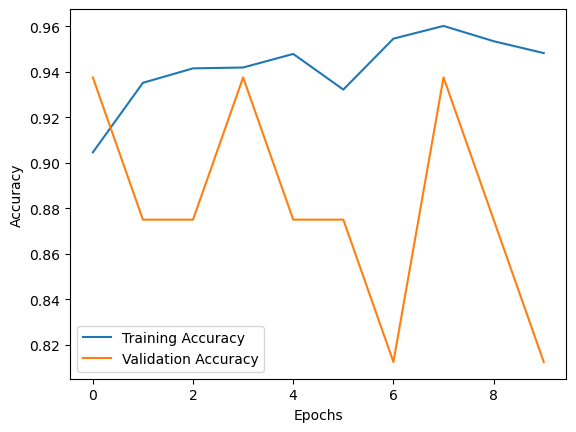

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

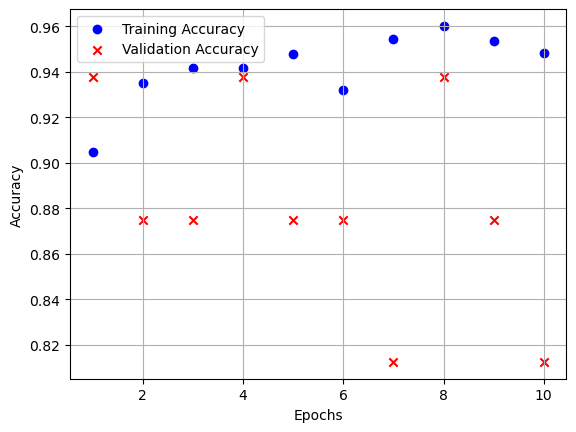

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)
plt.scatter(epochs, history.history['accuracy'], label='Training Accuracy', marker='o', color='blue')
plt.scatter(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='x', color='red')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


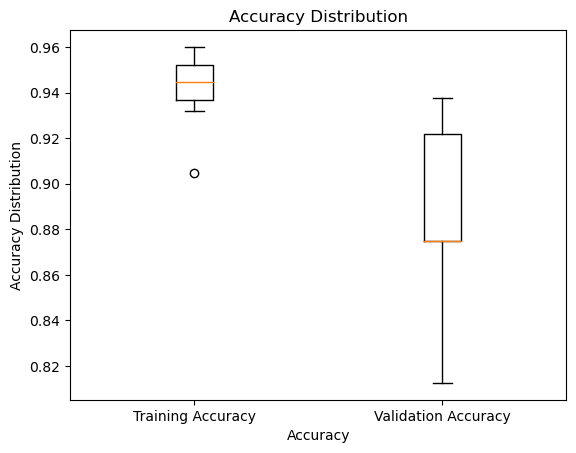

In [23]:
import matplotlib.pyplot as plt

plt.boxplot([history.history['accuracy'], history.history['val_accuracy']], labels=['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Accuracy')
plt.ylabel('Accuracy Distribution')
plt.title('Accuracy Distribution')
plt.show()


In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array, verbose=0)

    predicted_class_number = round(predictions[0][0])
    predicted_class = class_names[predicted_class_number]
    confidence = round(100*(predictions[0][0]), 2)
    if confidence<50: confidence=100-confidence
    return predicted_class, confidence, predicted_class_number

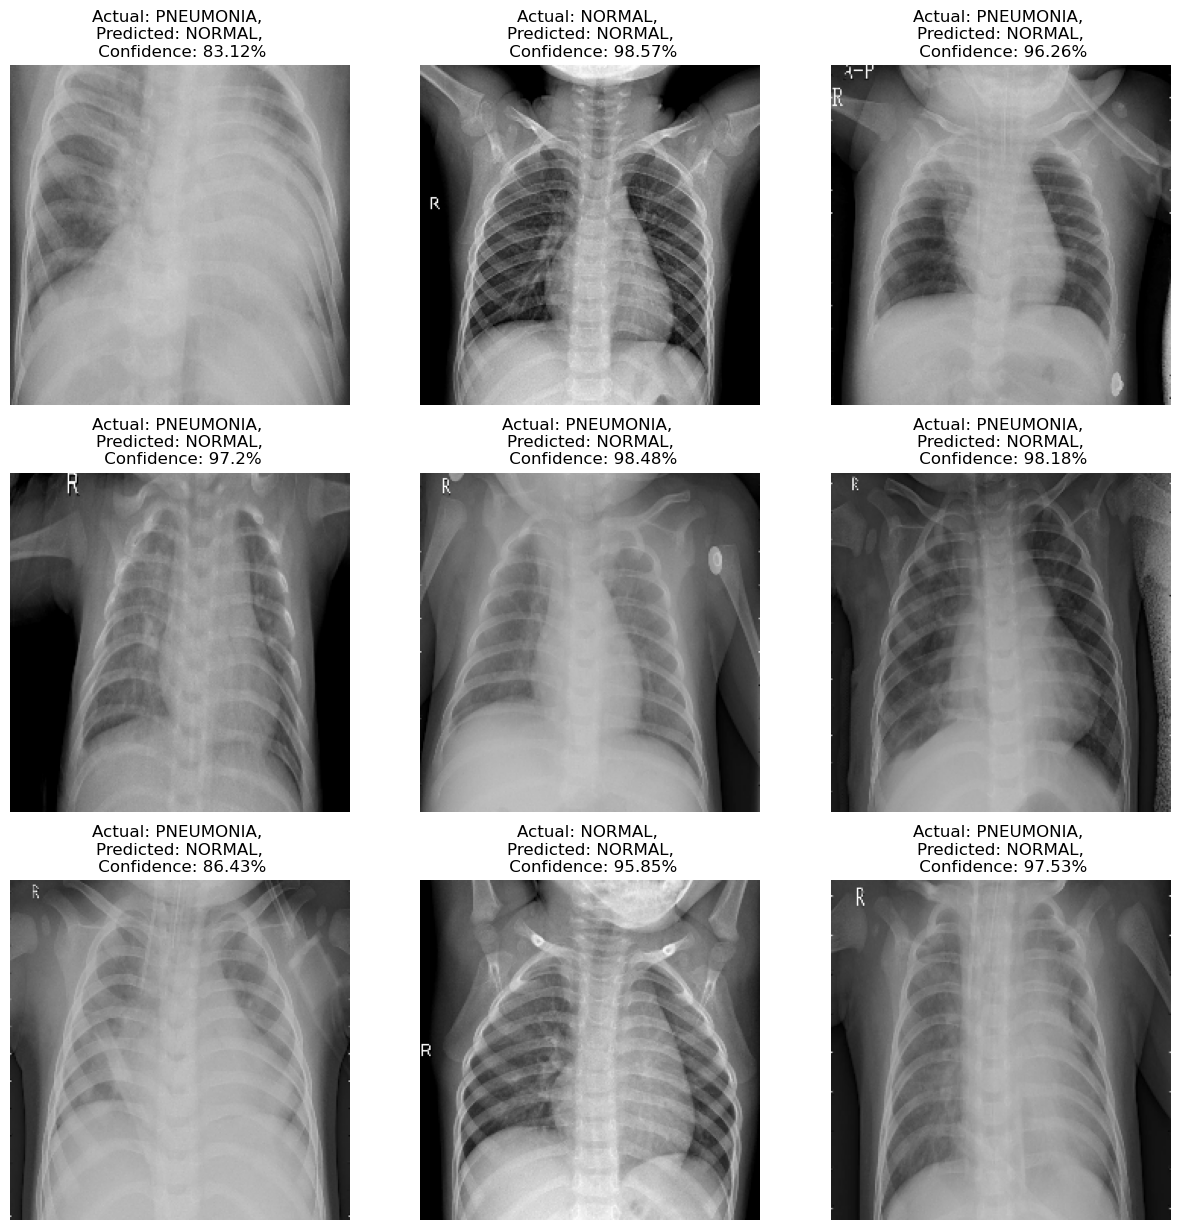

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence, predicted_class_number = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

19/19 [==============================] - 16s 728ms/step
Confusion Matrix:
[[148   0]
 [459   1]]


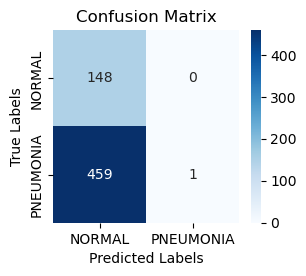

In [26]:
test_images = []
true_labels = []
for images, labels in test_ds:
    test_images.extend(images.numpy())
    true_labels.extend(labels.numpy())

test_images = np.array(test_images)
true_labels = np.array(true_labels)

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.rint(predictions)  # Rounding predictions to obtain predicted labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(3, 2.5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix") 
plt.show()
